In [1]:
# libraries
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler

import collections

import gym
import random

import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import os
import scipy.io as sio
from scipy.fft import fft


### DDQN model with CNN:

In [2]:
# load the dataset, returns train and test X and y elements
def load_dataset():

	# load all data
	with open('data/processed/trainX.npy', 'rb') as f:
		trainX = np.load(f)
	with open('data/processed/trainy.npy', 'rb') as f:
		trainy = np.load(f)
	with open('data/processed/testX.npy', 'rb') as f:
		testX = np.load(f)
	with open('data/processed/testy.npy', 'rb') as f:
		testy = np.load(f)
	
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	
	return trainX, trainy, testX, testy

In [3]:
# define model
def get_model(trainX, trainy, learning_rate):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=3, kernel_size=5, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
    
    return model

In [4]:
Experience = collections.namedtuple('Experience', 
           field_names=['state', 'action', 'reward', 
           'new_state', 'done'])
           
class ExperiencePool:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
        self.pool_counter= 0

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)
        self.pool_counter += 1
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), \
                np.array(rewards,dtype=np.float32), \
                np.array(next_states), \
                np.array(dones, dtype=np.uint8)

In [5]:
class DDQNAgent(object):
    def __init__(self, learning_rate, discount_factor, action_space,
                 trainX, trainy, batch_size,
                 epsilon_decay, epsilon_min, epsilon_0,
                 mem_size, replace_target):
        
        self.action_space = action_space
        self.n_actions = 3
        self.gamma = discount_factor

        self.epsilon_min = epsilon_min
        self.epsilon_0 = epsilon_0
        self.epsilon_decay = epsilon_decay
        self.epsilon = self.epsilon_min + (self.epsilon_0-self.epsilon_min)*np.exp(-self.epsilon_decay)
        self.reward_count = 0

        self.batch_size = batch_size
        self.replace_target = replace_target
        self.pool = ExperiencePool(mem_size)
        
        self.q_policy = get_model(trainX, trainy, learning_rate)
        self.q_target = get_model(trainX, trainy, learning_rate)
        self.update_network_parameters()

    def update_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_0-self.epsilon_min)*np.exp(-self.epsilon_decay*self.episode_count)

    def reset_pool(self, mem_size):
        self.pool = ExperiencePool(mem_size)

    def set_episode_count(self, episode_count):
        self.episode_count = episode_count

    def add_experience(self, experience): #state, action, reward, new_state, done
        self.pool.append(experience) #state, action, reward, new_state, done

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_policy.predict(state,verbose=0)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.pool.pool_counter >= self.batch_size:
            states, actions, rewards, new_states, dones = self.pool.sample(self.batch_size)

            q_next_target = self.q_target.predict(new_states, verbose=0)
            q_policy_next = self.q_policy.predict(new_states, verbose=0)
            q_policy_pred = self.q_policy.predict(states, verbose=0)

            max_actions = np.argmax(q_policy_next, axis=1)

            y_j = q_policy_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            y_j[batch_index, actions] = rewards + \
                    self.gamma*q_next_target[batch_index, max_actions.astype(int)]*dones

            history = self.q_policy.fit(states, y_j, verbose=2)
            
            if self.episode_count % self.replace_target == 0:
                self.update_network_parameters()

            return history.history['accuracy'], history.history['loss']
        return 0,0

    def update_network_parameters(self):
        self.q_target.set_weights(self.q_policy.get_weights())

In [6]:
class PowerPlantEnv(gym.Env):
    def __init__(self, dataset):
        super().__init__()
        self.action_space = gym.spaces.Discrete(3) # 3 classes
        self.x, self.y = dataset

    def step(self, action):
        if action == self.expected_action:
            reward = 1
        else:
            reward = -1
            
        obs = self._next_obs()

        return obs, reward, False, {}

    def _next_obs(self):
        next_obs_idx = random.randint(0, len(self.x) - 1)
        self.expected_action = np.argmax(self.y[next_obs_idx])
        obs = self.x[next_obs_idx]

        return obs


Training:

In [14]:
# Initialization:

# environment
trainX, trainy, testX, testy = load_dataset() # load dataset (x = state, y = action)

env = PowerPlantEnv(dataset=(trainX, trainy))
action_space = [0,1,2] # action space: {0: healthy, 1: OR fault, 2: IR fault}

E = 900 # training episode number
M = 300 # experience pool capacity
R = 64 # replay size
T = 64 # game rounds in one episode
C = 10 # copy period: training steps to update periodicity of target network

discount_factor = 0.05 # gamma
learning_rate = 0.001 # alpha

# epsilon-greedy:
# tradeoff between exploration and exploitation
epsilon_0 = 0.4  # exploration probability at start
epsilon_min = 0.01  # minimum exploration probability
epsilon_decay = 0.3  # exponential decay rate for exploration prob

cum_reward_episode = []
acc_episode = []
loss_episode = []
best_acc = []
best_weights = []

ddqn_agent = DDQNAgent(learning_rate=learning_rate, discount_factor=discount_factor, \
                                action_space=action_space, \
                                trainX=trainX, trainy=trainy, batch_size=R, \
                                epsilon_0=epsilon_0, epsilon_decay=epsilon_decay, \
                                epsilon_min=epsilon_min, mem_size=M, replace_target=C)

for e in range(1,E+1): # training episode
    env = PowerPlantEnv(dataset=(trainX, trainy)) # reset environment
    ddqn_agent.reset_pool(M) # reset experience pool
    ddqn_agent.set_episode_count(e) # set the counter with the number of episodes
    cum_reward = 0
    print("\n>> Episode: ",e,"/",E)
    observation = env._next_obs()
    ddqn_agent.update_epsilon()
    for t in range(1,T+1): # game round
        action = ddqn_agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        done = (t==T)
        cum_reward += reward
        exp = Experience(observation, action, reward, observation_, int(done))
        ddqn_agent.add_experience(exp)
        observation = observation_
        acc, loss = ddqn_agent.learn()
    if acc > best_acc: # save weights if accuracy improves
        best_acc = acc
        best_weights = ddqn_agent.q_policy.get_weights()
    cum_reward_episode.append(cum_reward)
    acc_episode.append(acc)
    loss_episode.append(loss)
    print("Cummulative reward: ",cum_reward)

# save best model
ddqn_model = ddqn_agent.q_policy
ddqn_model.set_weights(best_weights)
models_dir = 'models/'
existing_models = [filename for filename in os.listdir(models_dir) if filename.startswith('ddqn_model')]
num_model = len(existing_models)+1
filename = f'models/ddqn_model_{num_model}.h5'
ddqn_model.save(filename)

(49209, 512, 2) (49209, 3) (10545, 512, 2) (10545, 3)

>> Episode:  1 / 900
2/2 - 1s - loss: 0.4406 - accuracy: 0.3750 - 517ms/epoch - 258ms/step
Cummulative reward:  -20

>> Episode:  2 / 900
2/2 - 0s - loss: 0.4696 - accuracy: 0.3750 - 69ms/epoch - 34ms/step
Cummulative reward:  -26

>> Episode:  3 / 900
2/2 - 0s - loss: 0.4715 - accuracy: 0.3125 - 71ms/epoch - 35ms/step
Cummulative reward:  -26

>> Episode:  4 / 900
2/2 - 0s - loss: 0.4497 - accuracy: 0.3906 - 71ms/epoch - 35ms/step
Cummulative reward:  -22

>> Episode:  5 / 900
2/2 - 0s - loss: 0.4687 - accuracy: 0.4062 - 68ms/epoch - 34ms/step
Cummulative reward:  -28

>> Episode:  6 / 900
2/2 - 0s - loss: 0.4350 - accuracy: 0.3438 - 67ms/epoch - 33ms/step
Cummulative reward:  -18

>> Episode:  7 / 900
2/2 - 0s - loss: 0.3772 - accuracy: 0.4531 - 70ms/epoch - 35ms/step
Cummulative reward:  -2

>> Episode:  8 / 900
2/2 - 0s - loss: 0.4269 - accuracy: 0.4062 - 73ms/epoch - 36ms/step
Cummulative reward:  -16

>> Episode:  9 / 900
2/2

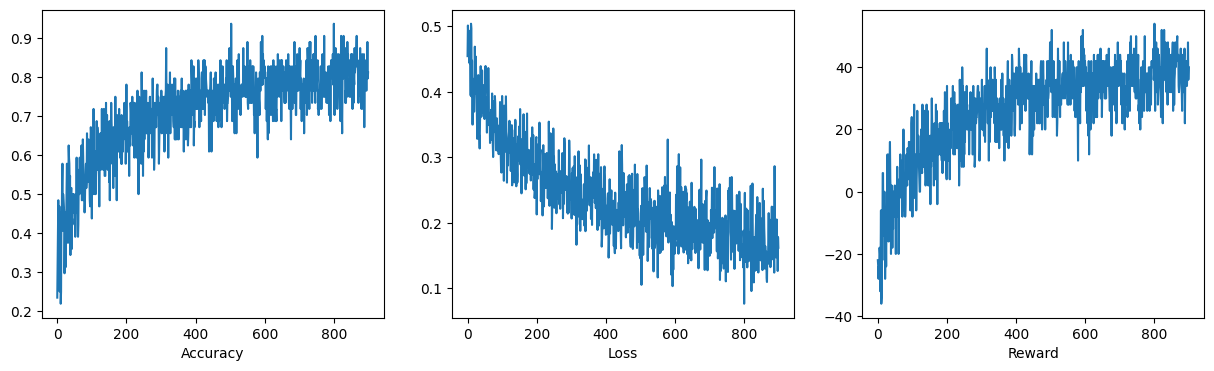

In [12]:
# E = 900 # training episode number ==> aumentar epochs
# M = 300 # experience pool capacity
# R = 64 # replay size
# T = 64 # game rounds in one episode
# C = 10 # copy period: training steps to update periodicity of target network
# discount_factor = 0.001 # gamma
# learning_rate = 0.001 # alpha
# # epsilon-greedy:
# # tradeoff between exploration and exploitation
# epsilon_0 = 0.4  # exploration probability at start
# epsilon_min = 0.01  # minimum exploration probability
# epsilon_decay = 0.3  # exponential decay rate for exploration prob
# Modelo con 2 capas de Conv1D
# con datos normalizados!
# guardando el mejor modelo, no el último

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [13]:
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 5s 16ms/step
Test accuracy:  0.7735419630156473


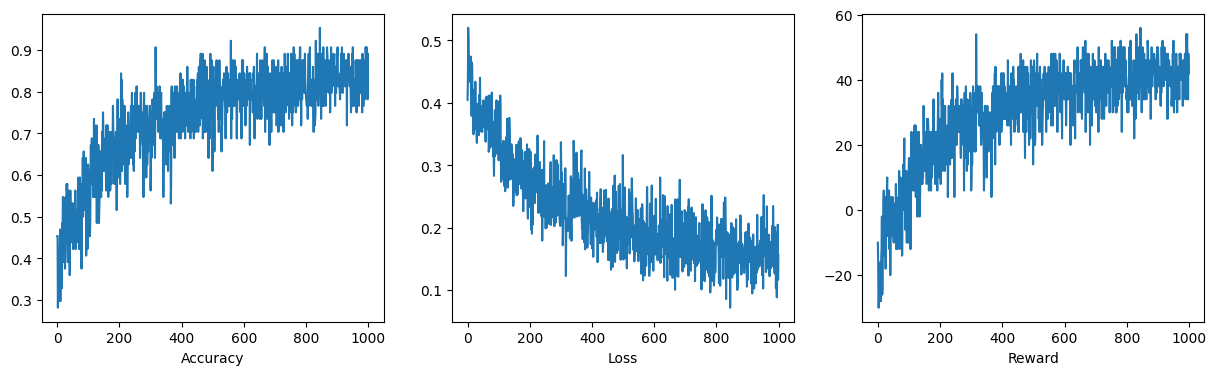

In [15]:
# E = 1000 # training episode number ==> aumentar epochs
# M = 300 # experience pool capacity
# R = 64 # replay size
# T = 64 # game rounds in one episode
# C = 10 # copy period: training steps to update periodicity of target network
# discount_factor = 0.01 # gamma
# learning_rate = 0.001 # alpha
# # epsilon-greedy:
# # tradeoff between exploration and exploitation
# epsilon_0 = 0.4  # exploration probability at start
# epsilon_min = 0.01  # minimum exploration probability
# epsilon_decay = 0.3  # exponential decay rate for exploration prob
# Modelo con 2 capas de Conv1D
# con datos normalizados!
# guardando el mejor modelo, no el último

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [16]:
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 8s 24ms/step
Test accuracy:  0.8221906116642959


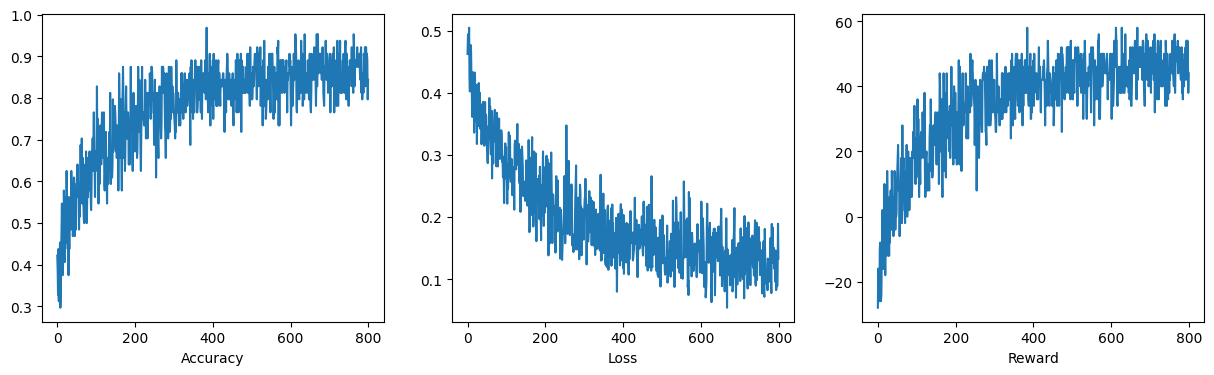

In [11]:
# E = 800 # training episode number ==> aumentar epochs
# M = 300 # experience pool capacity
# R = 64 # replay size
# T = 64 # game rounds in one episode
# C = 10 # copy period: training steps to update periodicity of target network
# discount_factor = 0.01 # gamma
# learning_rate = 0.001 # alpha
# # epsilon-greedy:
# # tradeoff between exploration and exploitation
# epsilon_0 = 0.4  # exploration probability at start
# epsilon_min = 0.01  # minimum exploration probability
# epsilon_decay = 0.3  # exponential decay rate for exploration prob
# Modelo con 2 capas de Conv1D
# con datos normalizados!

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(acc_episode)
axs[0].set(xlabel='Accuracy')

axs[1].plot(loss_episode)
axs[1].set(xlabel='Loss')

axs[2].plot(cum_reward_episode)
axs[2].set(xlabel='Reward')

plt.show()

In [13]:
pred_test = ddqn_model.predict(testX)

test_acc = accuracy_score(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
print('Test accuracy: ',test_acc)

330/330 [==============================] - 5s 15ms/step
Test accuracy:  0.8537695590327169


In [14]:
print(classification_report(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1), target_names=['Healthy', 'OR fault', 'IR fault'],digits=4))

              precision    recall  f1-score   support

     Healthy     0.9129    0.8440    0.8771      3552
    OR fault     0.9260    0.8061    0.8619      3600
    IR fault     0.7519    0.9145    0.8253      3393

    accuracy                         0.8538     10545
   macro avg     0.8636    0.8549    0.8548     10545
weighted avg     0.8656    0.8538    0.8552     10545



In [15]:
# testing
# Construimos una visualización para la matriz de confusión
z_test = confusion_matrix(np.argmax(testy,axis=1), np.argmax(pred_test,axis=1))
# Reformateo la matriz para que me quede mejor el gráfico
z_test[[0,2],:] = z_test[[2,0],:]
x = ['Healthy', 'OR fault', 'IR fault']
y = ['IR fault', 'OR fault', 'Healthy']
z_text = [[str(y) for y in x] for x in z_test]
heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='tealrose')
heatmap.update_layout(title_text='Testing',height=300,width=600,
                      xaxis_title="Predicted Label",yaxis_title="True Label")
heatmap.show()